<center>
Reinforcement Learning
    
# Homework 6 - On-policy Control with Approximation

    
</center>

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone. 
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [97]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gym

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


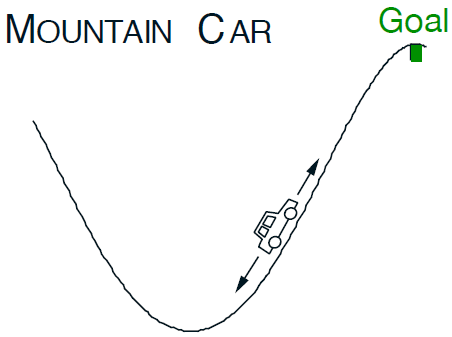


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. 

**Observation space**

The observation is two dimensional including the position of the car along the x-axis and velocity of the car.

**Action space**

There are three deterministic actions: 0 accelerate to the left, 1 do nothing, and 2 accelerate to the right.

**Transition dynamics**

The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 (A_t-1) - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.6$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. 

**Reward**

The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. 

**Initial State**

Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.

**Goal and Termination**

The episode terminates when the position of the car is greater than or equal to 0.5 (the goal position on top of the right hill).

**Arguments**

> env = gym.make('MountainCar-v0')

**Note**

Do not use the Continuous Mountain Car environment for this homework.
> gym.make('MountainCarContinuous-v0')


## Part I (4 points)

Check and confirm that the given Mountain Car simulation works as expected. Make sure you can observe and log (if needed) all the observations, actions, rewards, and termination conditions. You can animate the simulation by adding `render_mode='human'` when calling the `gym.make` class.  


In [ ]:
#--- Your code here ---
env = gym.make('MountainCar-v0', render_mode="human")
observation, info = env.reset()
print(f'observation: {observation}')
terminated = False
while not terminated:
    action = np.random.randint(3)
    observation, reward, terminated, truncated, info = env.step(action)
env.reset()
env.close()

## Part II (6 points)

In this part, you will practice writing code for approximating the state value function. 

(a) write a function that generates Fourier basis features for a problem with one continuous state (1D state). The output of this function should be a vector of Fourier basis functions,
$X(s) = [\cos(0 * \pi * s), ..., \cos(n * \pi * s)]$ where $n$ represents the approximation order.

(b) Write a function that given a state $S$ and a weight vector $w$ calculates $V(S, w)$ by multiplying $w$ and $X(S)$. Make sure this is a vector-vector multiplication and avoid using for loops. Test your function with different values of $w$ and $S$. 

(c) Does $S$ need to be bounded? If yes, how would you do that?



In [1]:
#--- Your code here ---
# Question II(a)
def fourier_1d(n,s):
    s = normalize(state=s)
    X = np.zeros(n+1)
    for i in range(n+1):
        X[i,1] = np.cos(i*np.pi*s)
    return X
# Question II(b)
def value_sw(s,w):
    V = np.zeros()
    V = np.matmul(np.transpose(w),fourier_1d(n,s))
# Question II(c)
def normalize(state):
    state = (state-min_state)/(max_state-min_state)
    return state

# II (c)
S needs to be bounded in the range of [0,1]. The normalization is performed by max_min_normalization method, as shown in the answer above.

## Part III (40 points)

Implement the **Episodic Semi-gradient SARSA** (pp. 244).

In [89]:
# semi-gradient SARSA
class SemiSarsa:

    def __init__(self,n, gamma, alpha, epsilon):
        self.episode_step = None
        self.episode_reward = None
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.n = n
        self.feature_space = (self.n + 1)**2
        self.w = {}
        self.env = gym.make('MountainCar-v0')
        self.action_space = self.env.action_space.n

    def initialize(self):
        for i in range(self.action_space):
            self.w[i] = np.zeros((1, self.feature_space))

    def state_normalize(self,state):
         state = (state - self.env.observation_space.low) / (self.env.observation_space.high - self.env.observation_space.low)
         return state

    def fourier_2d(self,s):
        coeff = np.array([[i,j] for i in range(self.n+1) for j in range(self.n+1)])
        self.x = np.cos(np.pi*np.matmul(s,coeff.transpose()))
        return self.x

    def argmax_q(self,S):
        max_q = []
        for i in range(self.action_space):
            max_q.append(self.calculate_q(S,i))
        if np.random.rand(1) >= self.epsilon:
            return np.argmax(max_q)
        else:
            return np.random.choice(self.action_space,1)[0]

    def calculate_q(self,S,A):
        return np.matmul(self.w[A], self.fourier_2d(S))

    def semi_sarsa(self,episodes, runs):
        self.episode_reward = np.zeros((runs, episodes))
        self.episode_step = np.zeros((runs, episodes))
        for run in range(runs):
            self.initialize()
            for episode in range(episodes):
                if (run == runs-1) and (episode == episodes-1):
                    self.env = gym.make('MountainCar-v0', render_mode="human")
                S, info = self.env.reset()
                S = self.state_normalize(S)
                A = self.argmax_q(S)
                self.step = 0
                self.rew = 0
                while True:
                    S_next, reward, terminated, truncated, info = self.env.step(A)
                    S_next = self.state_normalize(S_next)
                    if terminated:
                        self.w[A] += self.alpha * (reward - self.calculate_q(S,A)) * self.fourier_2d(S)
                        break
                    A_next = self.argmax_q(S_next)
                    coeff = reward + self.gamma * self.calculate_q(S_next, A_next) - self.calculate_q(S, A)
                    self.w[A] += self.alpha*coeff * self.fourier_2d(S)
                    S = S_next
                    A = A_next
                    self.step += 1
                    self.rew += reward
                self.episode_reward[run, episode] = self.rew
                self.episode_step[run, episode] = self.step

    def get_weights(self):
        return self.w

    def reward_plot(self):
        plt.figure(1, (10, 6))
        plt.plot(range(len(self.episode_reward[0, :])), np.mean(self.episode_reward, 0))
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        # plt.ylim([-300,20])
        plt.legend()
        plt.grid()
        plt.show()

    def step_plot(self):
        plt.figure(2, (10, 6))
        plt.plot(range(len(self.episode_step[0, :])), np.log10(np.mean(self.episode_step, 0)))
        plt.xlabel('Episodes')
        plt.ylabel('steps during episode')
        # plt.ylim([-200,10])
        plt.legend()
        plt.grid()
        plt.show()

## Part IV (50 points) 

(a) Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). 


(b) Plot sum of reward-per-episode vs. number of episodes. This plot should be averaged over 50-100 runs.


(c) Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.

(d) Animate the last episode in a selected run. Does the approximated policy seem optimal? Why?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


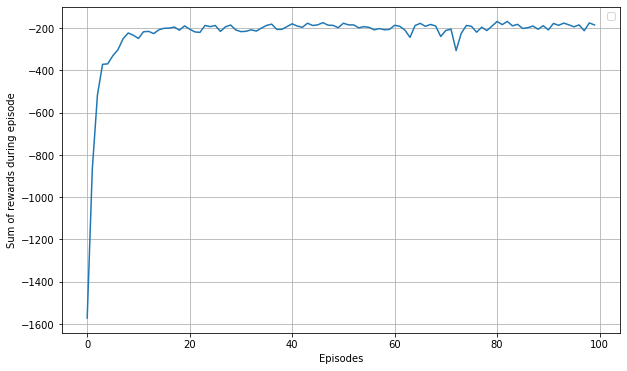

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


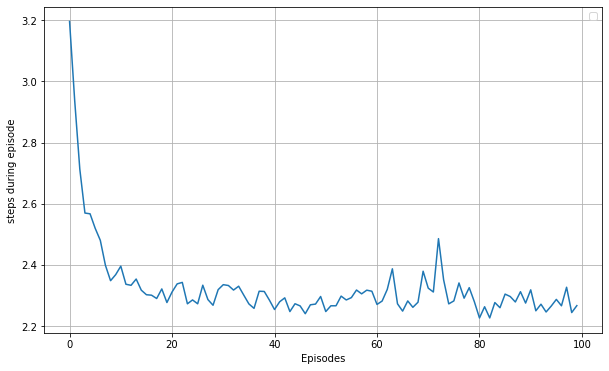

In [90]:
# Your code here
sarsa_instance = SemiSarsa(n=3,gamma=1,alpha=.01,epsilon=0.1)
sarsa_instance.semi_sarsa(100,60)

sarsa_instance.reward_plot()
sarsa_instance.step_plot()

**Part IV (d)**
> Answer: The approximated policy is optimal because the car moves back and forth minimal time to accelerate enough to reach the goal.

## Part V (Extra Points)

(a) Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

In [177]:
# Your code here
# semi-gradient n-step SARSA
import gym
class NstepSarsa:

    def __init__(self,n_fourier, gamma, alpha, epsilon):
        self.terminal_state = None
        self.terminated = None
        self.episode_step = None
        self.episode_reward = None
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.n_fourier = n_fourier
        self.feature_space = (n_fourier + 1)**2
        self.w = {}
        self.env = gym.make('MountainCar-v0')
        self.action_space = self.env.action_space.n
        # self.coeff = np.array([[i,j] for i in range(n_fourier+1) for j in range(n_fourier+1)])

    def initialize(self):
        for i in range(self.action_space):
            self.w[i] = np.zeros((1, self.feature_space))

    def state_normalize(self,state):
        state = (state - self.env.observation_space.low) / (self.env.observation_space.high - self.env.observation_space.low)
        return state

    def fourier_2d(self,s):
        coeff = np.array([[i,j] for i in range(self.n_fourier+1) for j in range(self.n_fourier+1)])

        self.x = np.cos(np.pi*np.matmul(self.state_normalize(s),coeff.transpose()))
        return self.x

    def argmax_q(self,S):
        max_q = []
        for i in range(self.action_space):
            max_q.append(self.calculate_q(S,i))
        if np.random.rand(1) > self.epsilon:
            return np.argmax(max_q)
        else:
            return np.random.choice(self.action_space,1)[0]

    def calculate_q(self,S,A):
        if S[0] >= 0.5: # this ensures Q is zero for terminal state
            return 0
        else:
            return np.matmul(self.w[A], self.fourier_2d(S))

    def nstep_sarsa(self,episodes, runs, n_step):
        n = n_step
        self.episode_reward = np.zeros((runs, episodes))
        self.episode_step = np.zeros((runs, episodes))
        for run in range(runs):
            self.initialize()
            self.env.reset()
            for episode in range(episodes):
                if (run == runs-1) and (episode == episodes-1):
                    self.env = gym.make('MountainCar-v0', render_mode="human")
                S, info = self.env.reset()
                A = self.argmax_q(S)
                T = np.inf
                actions = [A]
                states = [S]
                rewards = [0]
                t = 0
                self.step = 0
                self.rew = 0
                while True:
                    if t < T:
                        S_next, reward, self.terminated, truncated, info = self.env.step(A)
                        rewards.append(reward)
                        states.append(S_next)
                        if self.terminated:
                            T = t + 1
                        else:
                            A_next = self.argmax_q(S_next)
                            actions.append(A_next)
                    tao = t - n + 1
                    if tao >= 0:
                        G = 0
                        for i in np.arange(tao + 1, np.minimum(tao + n + 1, T + 1)):
                            G += np.power(self.gamma, i - tao - 1) * rewards[int(i)]
                        if tao + n < T:
                            G += np.power(self.gamma, n) * self.calculate_q(states[tao + n],actions[tao + n])
                        self.w[actions[tao]] += self.alpha * (G - self.calculate_q(states[tao],actions[tao]))* self.fourier_2d(states[tao])
                    if tao == T - 1:
                        break
                    t += 1
                    if t%100000==0:
                        print(self.w)
                    #     print(states)

                self.episode_reward[run, episode] = np.sum(rewards.copy())
                self.episode_step[run, episode] = t

    def get_weights(self):
        return self.w

    def reward_plot(self):
        plt.figure(1, (10, 6))
        plt.plot(range(len(self.episode_reward[0, :])), np.mean(self.episode_reward, 0))
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        # plt.ylim([-300,20])
        plt.legend()
        plt.grid()
        plt.show()

    def step_plot(self):
        plt.figure(2, (10, 6))
        plt.plot(range(len(self.episode_step[0, :])), np.log10(np.mean(self.episode_step, 0)))
        plt.xlabel('Episodes')
        plt.ylabel('steps during episode')
        # plt.ylim([-200,10])
        plt.legend()
        plt.grid()
        plt.show()

(b) Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [ ]:
# Your code here
instance_nstep = NstepSarsa(n_fourier=3,gamma=.9999,alpha=0.05,epsilon=0.1)
instance_nstep.nstep_sarsa(2,1,8)
instance_nstep.step_plot()